## Email classifier

We will build a tool to classify emails. This will involve


1.   Reading the emails
2.   Asking a local LLM with a good prompt to classify the emails
3.   Asking that LLM with added examples to classify the emails
4.   Classification fine tuning that LLM to improve accuracy

Also covered
5.   Load from a particular email type gmail, outlook
6.   Find the most similar email to this we have seem=n before
7.   summarise the email
8.   Get some other metric for the email, sentiment, importance
9.   Have this run regularly
10.   Visualisation


##email classification

Learn to classify emails
And then do your own project

##dataset

dataset is at https://www.kaggle.com/datasets/wcukierski/enron-email-dataset
and https://www.cs.cmu.edu/~enron/
we want to load the data and parse it out.

first we need a version thats classified with nice categories
1. Spam ham https://github.com/crossedbanana/Enron-Email-Classification
2. company categories https://github.com/honcyeung/Enron-Email-Classification

lets go with 2

In [1]:
1+1

2

In [2]:
#load in libraries we will use
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, callbacks
from keras.regularizers import l1
import pickle
import nltk
from random import randint, choice
import warnings
from flask import Flask, render_template, request

ModuleNotFoundError: No module named 'tensorflow'

In [2]:


# clone the repo containing the dataset
!git clone https://github.com/honcyeung/Enron-Email-Classification.git
# change directory to the repo
%cd Enron-Email-Classification
# list the files in the directory to see the data
!ls

Cloning into 'Enron-Email-Classification'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 3.66 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Enron-Email-Classification
app_input.ipynb  code.ipynb  enron_dataset.csv	README.md  templates


In [3]:
# prompt: load enron_dataset.csv in the # clone the repo containing the dataset
# !git clone https://github.com/honcyeung/Enron-Email-Classification.git
# # change directory to the repo
# %cd Enron-Email-Classification
# # list the files in the directory to see the data
# !ls you just ran

import pandas as pd
df = pd.read_csv('enron_dataset.csv', sep=';')
print(df.head())

   Unnamed: 0                                      Target  \
0           0                     internal company policy   
1           1                    alliances / partnerships   
2           2                 internal company operations   
3           3                 internal company operations   
4           4  internal projects -- progress and strategy   

                                             Message  
0  Message-ID: <32715630.1075840547840.JavaMail.e...  
1  Message-ID: <8721012.1075863428380.JavaMail.ev...  
2  Message-ID: <8687721.1075852656109.JavaMail.ev...  
3  Message-ID: <16562450.1075846168630.JavaMail.e...  
4  Message-ID: <955111.1075858690252.JavaMail.eva...  


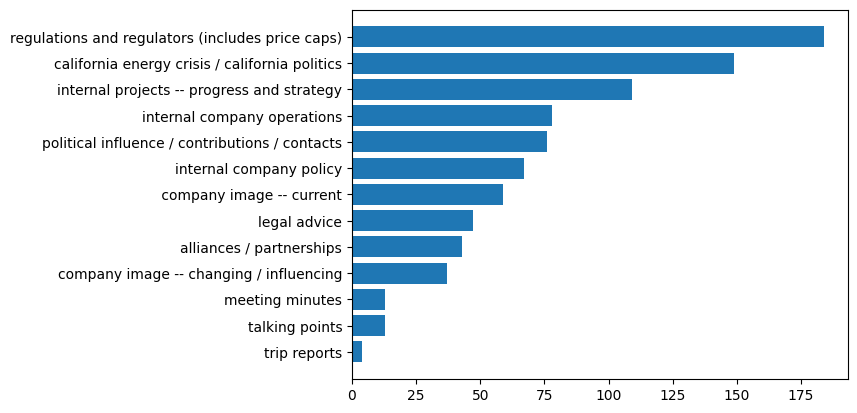

In [4]:

# visualize counts of each label

target_count = df.Target.value_counts()
plt.barh(target_count.index, target_count)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1]);

lets remove rare cases

In [5]:
rare_classes = [
    "meeting minutes",
    "talking points",
    "trip reports"
]

df = df[~df["Target"].isin(rare_classes)].reset_index(drop=True)



meeting minutes
talking points
trip reports


## extract columns from emails

we want to turn emails into discrete bits of information. Like who sent the email.

In [3]:
# define a function to extract the datetime from emails

def get_datetime(message):
    date = message.split('\n')[1][11:-12]
    return datetime.strptime(date, '%d %b %Y %H:%M:%S')

In [4]:
# define a function to extract the subject from emails

def get_subject(message):

    subject = message.split('\n')
    for s in subject:
        if s.startswith('Subject'):
            return s[9:]

In [5]:
# list to store elements(email heading) to be removed

element_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
 'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
 'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --']

In [6]:
# define a function to get the email content from message

def get_content(message):

    message = message.split('\n')
    message_copy = [ele for ele in message if ele != '']

    # remove the unwanted elements in the message
    for m in message:
        for e in element_to_drop:
            if m.startswith(e):
                message_copy.remove(m)
    return message_copy

In [7]:
# define a function to get senders of email

def get_sender(text):
    return text.split('\n')[2][6:]

In [8]:
# define a function to get receivers of email

def get_receiver(message):

    l = []
    for m in message:
        if m.startswith('X-To'):
            l.append(m[6:])
            l = l[0].split(', ')

    return l

In [9]:
# add receivers of email to the dataset

df2 = df.copy()
df2['Receiver'] = df2.Message.apply(lambda x: x.split('\n'))
df2['Receiver'] = df2.Receiver.apply(get_receiver)
df2.Receiver.head()

NameError: name 'df' is not defined

In [13]:
# define a dictionary to create key-value pairs of labels
# Strip whitespace from labels
df['Target'] = df['Target'].str.strip()

labels = df.Target.unique()
labels_num = np.arange(len(labels))
labels_dict = dict(zip(labels_num, labels))
labels_dict

{np.int64(0): 'internal company policy',
 np.int64(1): 'alliances / partnerships',
 np.int64(2): 'internal company operations',
 np.int64(3): 'internal projects -- progress and strategy',
 np.int64(4): 'regulations and regulators (includes price caps)',
 np.int64(5): 'company image -- current',
 np.int64(6): 'california energy crisis / california politics',
 np.int64(7): 'political influence / contributions / contacts',
 np.int64(8): 'legal advice',
 np.int64(9): 'company image -- changing / influencing'}

In [14]:
df.head()

,Unnamed: 0,Target,Message
0,0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...


In [15]:
df.rename(columns={"Unnamed: 0": "Message_ID"}, inplace=True)
df.head()

,Message_ID,Target,Message
0,0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...


In [16]:
df["Subject"] = df["Message"].apply(get_subject)
df["Sender"] = df["Message"].apply(get_sender)
df["Datetime"] = df["Message"].apply(get_datetime)
df["Body"] = df["Message"].apply(lambda msg: "\n".join(get_content(msg)))
df["Receiver"] = df["Message"].apply(lambda x: get_receiver(x.split("\n")))

In [17]:
df["Text"] = df["Subject"].fillna('') + " " + df["Body"]

In [18]:
df.head()

,Message_ID,Target,Message,Subject,Sender,Datetime,Body,Receiver,Text
0,0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...,Confidential Information and Securities Trading,legalonline-compliance@enron.com,2001-07-11 08:29:27,Email:doug.gilbert-smith@enron.com - 713853931...,"[GILBERT-SMITH@mailman.enron.com, Gilbert-smit...",Confidential Information and Securities Tradin...
1,1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...,"FW: Venezuela FX and inflation forecasts, June...",j.kaminski@enron.com,2001-06-26 09:40:17,"Vince,\nFYI,\nGwyn\nCindy,\nPlease find attach...",['vkaminski@aol.com'],"FW: Venezuela FX and inflation forecasts, June..."
2,2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...,Enron Expatriates in India,steven.kean@enron.com,2001-06-13 06:05:07,"John Brindle, David Cromley and others in the ...","[Lay, Kenneth </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Enron Expatriates in India John Brindle, David..."
3,3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...,Re: PLEASE READ & RESPOND,steven.kean@enron.com,2000-08-21 00:30:00,Yes. Contact either Gia or John and get the b...,[Michael Terraso],Re: PLEASE READ & RESPOND Yes. Contact either...
4,4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...,FW: ISO's Response to BPA Rebuttal of Sheffrin...,b..sanders@enron.com,2001-06-16 17:36:06,Atty Client work product\nThis is something i...,"['sbishop@gibbs-bruns.com', 'jalexander@gibbs-...",FW: ISO's Response to BPA Rebuttal of Sheffrin...


In [19]:
# Already recommended earlier
df["Target"] = df["Target"].replace({
    "company image -- changing / influencing": "company image -- current"
})


In [20]:
def collapse_labels(label):
    if "company image" in label or "regulations" in label:
        return "reputation & regulation"
    elif "california" in label:
        return "energy"
    return label  # leave others untouched

df["Target_Collapsed"] = df["Target"].apply(collapse_labels)
df["Target"] = df["Target_Collapsed"]

In [21]:
topic_counts = df['Target'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
topic_counts.sort_values(by='Count', ascending=False, inplace=True)
topic_counts

,Topic,Count
0,reputation & regulation,280
1,energy,149
2,internal projects -- progress and strategy,109
3,internal company operations,78
4,political influence / contributions / contacts,76
5,internal company policy,67
6,legal advice,47
7,alliances / partnerships,43


In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["LabelId"] = label_encoder.fit_transform(df["Target"])


##classifier

### old school

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

#X = df["Body"]
X = df["Text"]
y = df["LabelId"]

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_vec = tfidf.fit_transform(X)


In [51]:
xxx from sklearn.feature_extraction.text import TfidfVectorizer

X = df["Text"]
y = df["LabelId"]

tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2)  # unigrams + bigrams
)

X_vec = tfidf.fit_transform(df["Subject"].fillna('') + " " + df["Body"])


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [46]:
xxx from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [25]:
# Predict
y_pred = clf.predict(X_test)

# Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


                                                precision    recall  f1-score   support

                      alliances / partnerships       1.00      0.11      0.20         9
                                        energy       0.78      0.47      0.58        30
                   internal company operations       0.57      0.25      0.35        16
                       internal company policy       0.75      0.23      0.35        13
    internal projects -- progress and strategy       0.38      0.27      0.32        22
                                  legal advice       0.00      0.00      0.00         9
political influence / contributions / contacts       0.50      0.20      0.29        15
                       reputation & regulation       0.42      0.88      0.56        56

                                      accuracy                           0.47       170
                                     macro avg       0.55      0.30      0.33       170
                              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


old way with 3 extra small classes of topics

                                        accuracy                           0.37       176
                                       macro avg       0.33      0.20      0.20       176
                                    weighted avg       0.41      0.37      0.33       176
                                    

## hugging face version

In [10]:
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 28.0 MB/s eta 0:00:00 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.1
    Uninstalling transformers-4.54.1:
      Successfully uninstalled transformers-4.54.1

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [27]:
from transformers import TrainingArguments

In [29]:
from datasets import Dataset
# Split and convert to HuggingFace Dataset format
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_ds = Dataset.from_dict({"text": test_texts, "label": test_labels})

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Find number of unique classes
num_labels = len(set(y))

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# Training configuration
training_args = TrainingArguments(
    output_dir="./distilbert-enron",
    eval_strategy="epoch", # Corrected argument name
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    save_strategy="no",
    logging_dir="./logs",
    load_best_model_at_end=False
)

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: name 'y' is not defined

In [ ]:
results = trainer.evaluate()
print(results)


## visuals

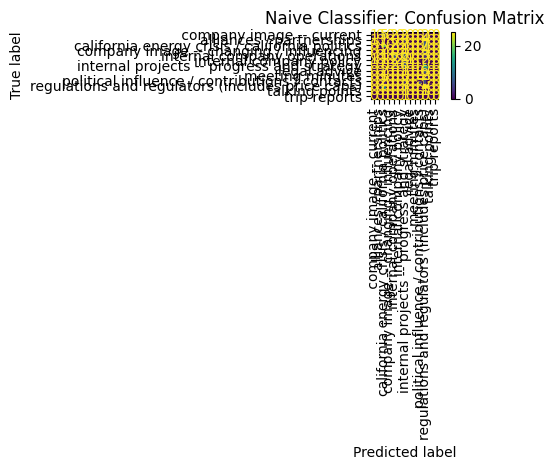

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=label_encoder.classes_, xticks_rotation='vertical'
)
plt.title("Naive Classifier: Confusion Matrix")
plt.tight_layout()
plt.show()


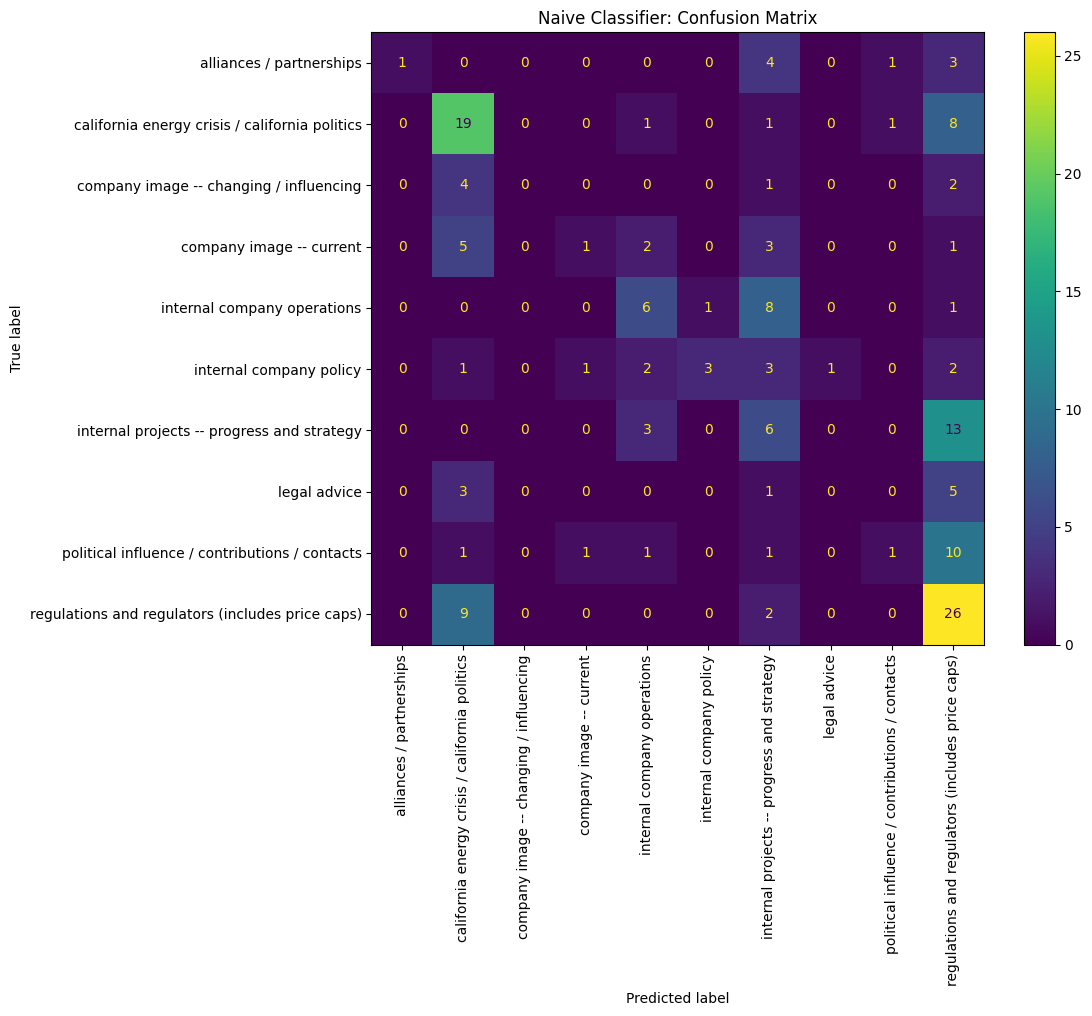

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))  # adjust size as needed

ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=label_encoder.classes_, xticks_rotation='vertical', ax=ax
)

plt.title("Naive Classifier: Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # save as high-res PNG
plt.show()


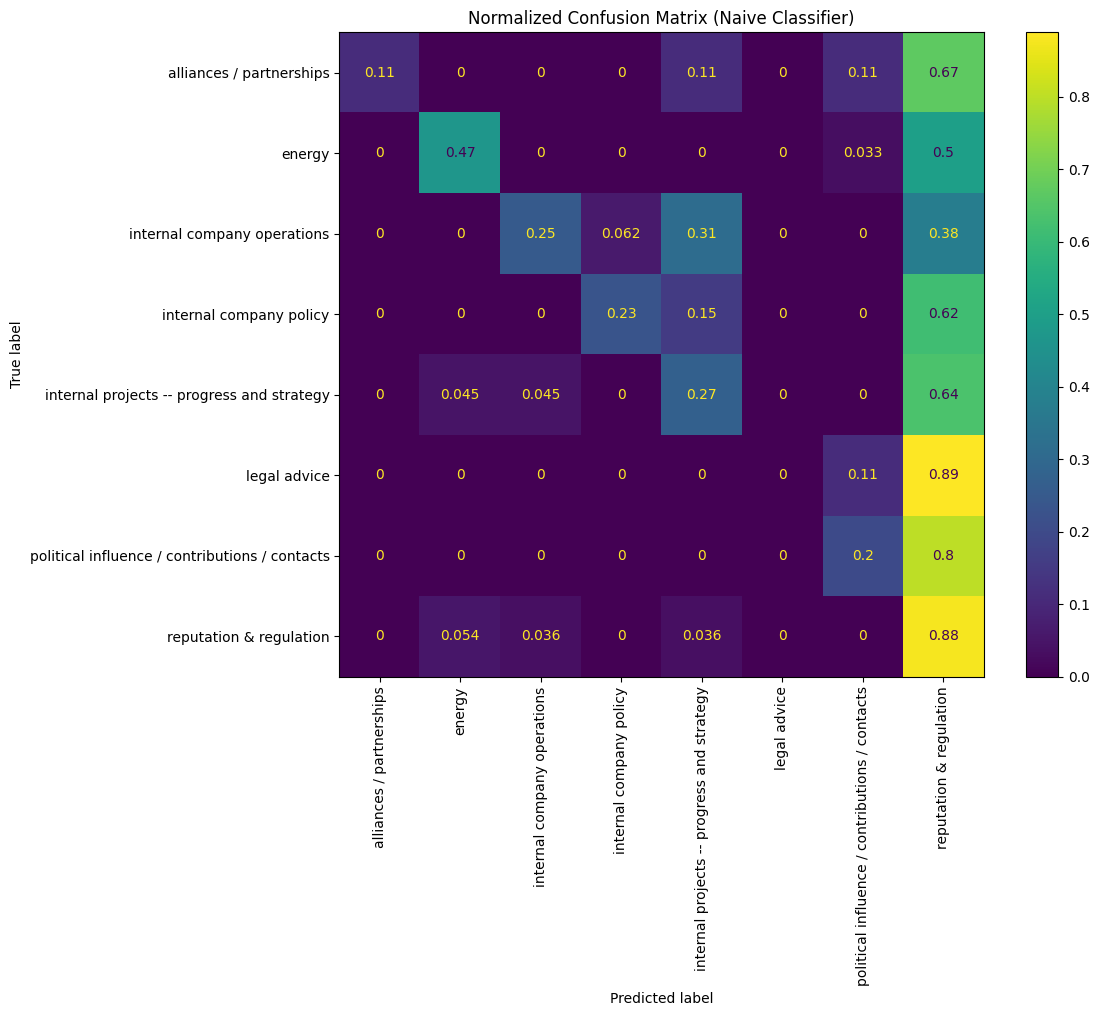

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix (Naive Classifier)")
plt.tight_layout()
plt.savefig("normalized_confusion_matrix.png", dpi=300)
plt.show()


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Encode string labels to numeric
label_encoder = LabelEncoder()
df["LabelId"] = label_encoder.fit_transform(df["Target"])

# 2. Prepare features and labels
X = df["Body"]
y = df["LabelId"]

# 3. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_vec = tfidf.fit_transform(X)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# 5. Train a naive classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


                                                  precision    recall  f1-score   support

                        alliances / partnerships       0.00      0.00      0.00         6
  california energy crisis / california politics       0.45      0.36      0.40        36
         company image -- changing / influencing       0.00      0.00      0.00        13
                        company image -- current       0.67      0.29      0.40         7
                     internal company operations       0.31      0.24      0.27        17
                         internal company policy       0.71      0.33      0.45        15
      internal projects -- progress and strategy       0.21      0.56      0.31        16
                                    legal advice       0.00      0.00      0.00        10
  political influence / contributions / contacts       0.25      0.08      0.12        13
regulations and regulators (includes price caps)       0.37      0.68      0.48        37

        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



How about
- Collab notebook
- enron email dataset
- notebook shows -prompt classification - prompt with examples
-then classification fine tune
-show people how to connect to Gmail, Outlook
-how to use schedule library

- second half help them build their own email classifier
- help them anonymise data to make it safer to work with

SyntaxError: invalid syntax (ipython-input-1-2928306079.py, line 1)

How about
- Collab notebook
- enron email dataset
- notebook shows -prompt classification - prompt with examples
-then classification fine tune
-show people how to connect to Gmail, Outlook
-how to use schedule library

-second half help them build their own email classifier
-helo them anonymise data to make it safer to work with

# Email Classification Notebook

This notebook demonstrates the process of classifying emails using a dataset from Kaggle. We will cover data loading, preprocessing, model training, and evaluation.

## Dataset

We will be using the Enron Email Dataset from Kaggle: [https://www.kaggle.com/datasets/wcukierski/enron-email-dataset](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset)

## Data Loading

In this section, we will load the dataset into a pandas DataFrame.

## Data Preprocessing

Here, we will clean and prepare the email data for classification.

## Model Selection and Training

We will choose a classification model and train it on the preprocessed data.

## Model Evaluation

We will evaluate the performance of the trained model.

## Demonstration

This section will show how to use the trained model to classify new emails.

## Conclusion

We will summarize the process and discuss potential next steps.